In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
image_path = 'image.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [5]:
def resize_image(image):
    dimensions = (200, 200)
    resized_linear = cv2.resize(image, dimensions, interpolation=cv2.INTER_LINEAR)
    resized_nearest = cv2.resize(image, dimensions, interpolation=cv2.INTER_NEAREST)
    resized_polynomial = cv2.resize(image, dimensions, interpolation=cv2.INTER_CUBIC)
    return resized_linear, resized_nearest, resized_polynomial

In [6]:
def blur_image(image):
    box_blur = cv2.blur(image, (5, 5))
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    adaptive_blur = cv2.bilateralFilter(image, 9, 75, 75)
    return box_blur, gaussian_blur, adaptive_blur

In [7]:
resized_linear, resized_nearest, resized_polynomial = resize_image(image)

In [8]:
box_blur, gaussian_blur, adaptive_blur = blur_image(image)

In [9]:
def plot_images(images, titles):
    plt.figure(figsize=(14, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

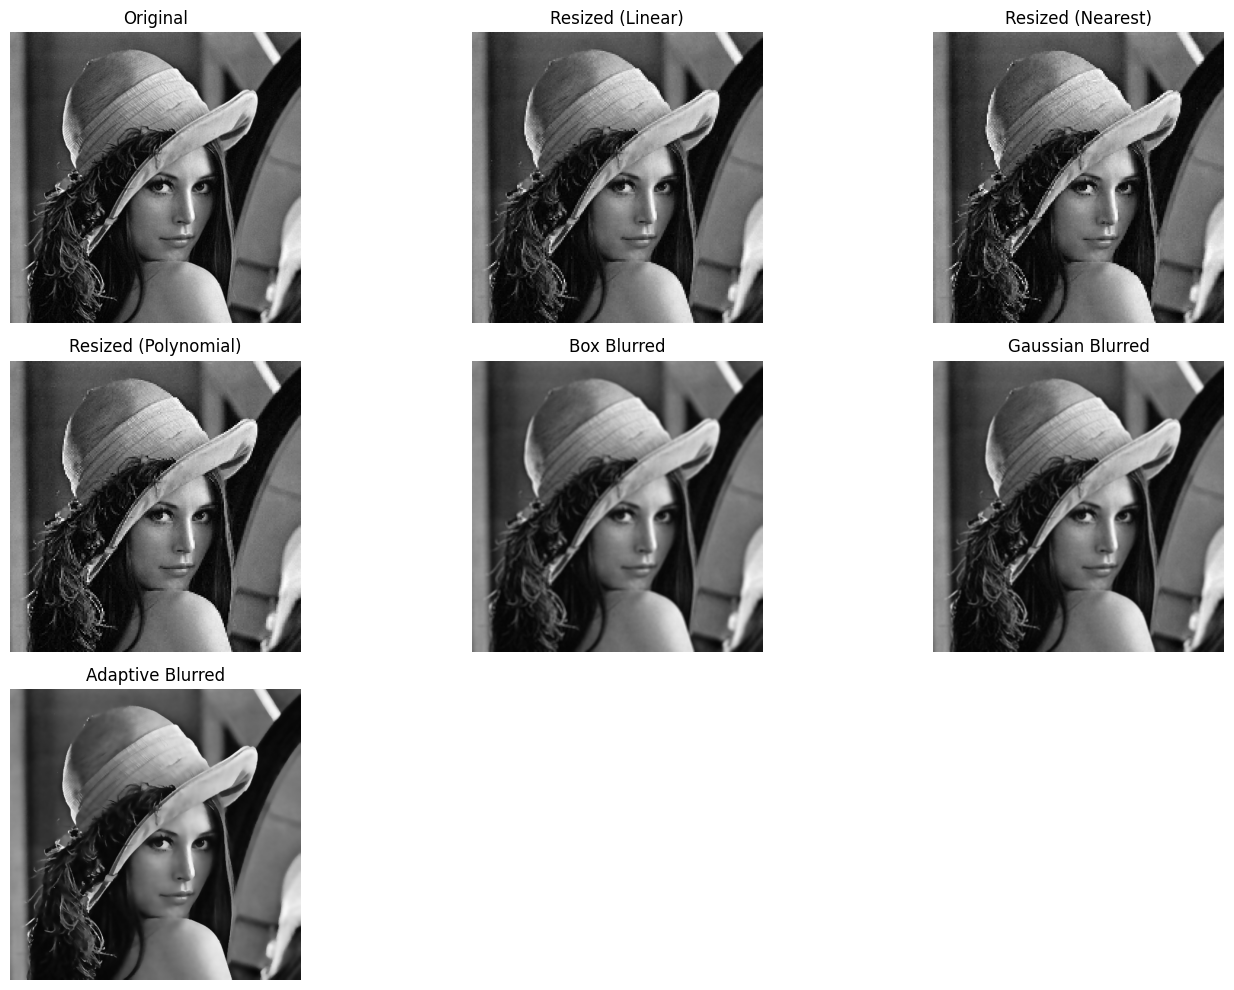

In [10]:
images = [image, resized_linear, resized_nearest, resized_polynomial, box_blur, gaussian_blur, adaptive_blur]
titles = [
    'Original', 'Resized (Linear)', 'Resized (Nearest)', 'Resized (Polynomial)',
    'Box Blurred', 'Gaussian Blurred', 'Adaptive Blurred'
]

plot_images(images, titles)

In [11]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [12]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [14]:
X = X.reshape(X.shape[0], -1).astype("float32") / 255.0

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "ANN": Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
models["ANN"].compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    if model_name == "ANN":
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred = np.argmax(model.predict(X_test), axis=1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test_bin, y_pred_bin, multi_class="ovr")
    return accuracy, precision, recall, f1, cm, roc_auc

In [20]:
results = {}

In [21]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    accuracy, precision, recall, f1, cm, roc_auc = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm,
        "ROC AUC": roc_auc,
    }
    if model_name != "ANN":
        cv_results = cross_validate(model, X_train, y_train, cv=kf, scoring=["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"])
        print(f"{model_name} - Cross-validation Results:")
        print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f}")
        print(f"Mean Precision: {cv_results['test_precision_weighted'].mean():.4f}")
        print(f"Mean Recall: {cv_results['test_recall_weighted'].mean():.4f}")
        print(f"Mean F1-Score: {cv_results['test_f1_weighted'].mean():.4f}\n")


Evaluating Random Forest...
Random Forest - Cross-validation Results:
Mean Accuracy: 0.9672
Mean Precision: 0.9672
Mean Recall: 0.9672
Mean F1-Score: 0.9672

Evaluating ANN...
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Results for Random Forest:
Accuracy: 0.9675
Precision: 0.9675
Recall: 0.9675
F1-Score: 0.9675
Confusion Matrix:
[[1325    0    4    0    1    1    3    1    6    2]
 [   0 1573    6    8    2    0    0    6    3    2]
 [   3    5 1335    4    5    1    9    8    8    2]
 [   1    0   23 1366    0    9    0   14   12    8]
 [   4    1    3    0 1256    0    2    3    3   23]
 [   1    3    3   17    4 1226    8    1    8    2]
 [   4    1    0    0    6   10 1372    0    3    0]
 [   3    5   15    0    7    1    0 1455    2   15]
 [   1    6    8   15    5   10    5    7 1293    7]
 [   4    6    5   16   20    5    1   10    9 1344]]
ROC AUC: 0.9819
Results for ANN:
Accuracy: 0.9726
Precision: 0.9728
Recall: 0.9726
F1-Score: 0.9725
Confusion Matrix:
[[1309    2    6    0    1    1   18    1    4    1]
 [   0 1589    2    0    1    0    1    5    2    0]
 [   0    9 1351    3    5    2    2    2    6    0]
 [   0    5   11 1386    2   15    0    4    5    5]
 [   0    1    2    0 1279 

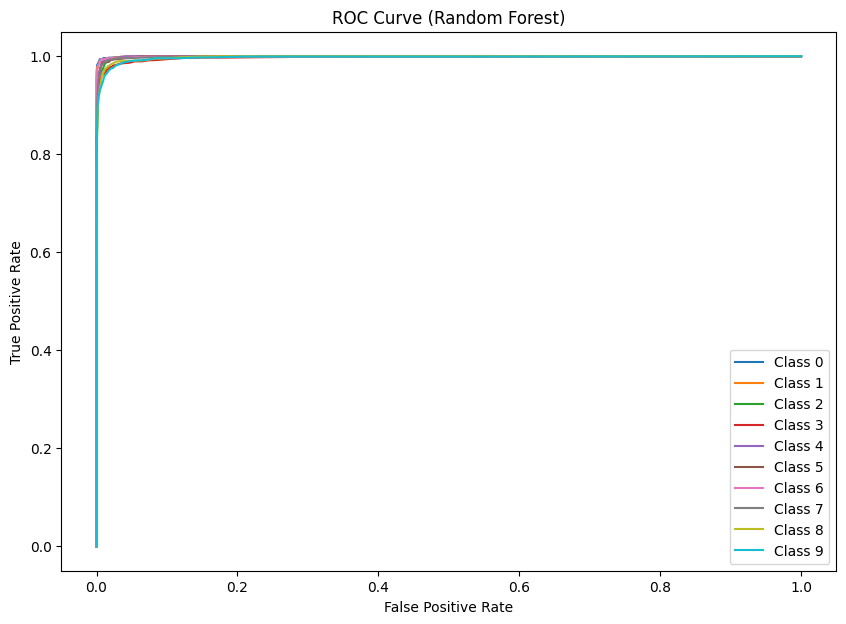

In [22]:
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for metric, value in metrics.items():
        if metric == "Confusion Matrix":
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value:.4f}")
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_prob = model_rf.predict_proba(X_test)
fpr = {}
tpr = {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=range(10))[:, i], y_pred_prob[:, i])

plt.figure(figsize=(10, 7))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"Class {i}")
plt.title("ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()